In [5]:
import copy
from datetime import datetime
import logging
import os
import time
from pathlib import Path

import matplotlib

# matplotlib.use("TkAgg")  # no UI backend
import pickle

import numpy as np
import timm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from pytorch_grad_cam import (
    AblationCAM,
    EigenCAM,
    FullGrad,
    GradCAM,
    GradCAMPlusPlus,
    HiResCAM,
    ScoreCAM,
    XGradCAM,
    EigenGradCAM
)
from pytorch_grad_cam.utils.image import (
    deprocess_image,
    preprocess_image,
    show_cam_on_image,
)
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm
from operator import attrgetter

from proxyattention.meta_utils import *
from proxyattention.training import choose_network, dict_gradient_method, inv_normalize, find_target_layer

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import time
import gc
import copy
import argparse as ap
import ast
import pandas as pd
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst


import cv2
import matplotlib.pyplot as plt

# sns.set()

cudnn.benchmark = True

computer_choice = "linux"
config = {}
# pc, cluster

# Make dirs
if computer_choice == "linux":
    main_run_dir = (
        "/media/eragon/data/CODE/thesis_runs/proper_runs/"
    )
    # main_ds_dir = "/media/eragon/HDD/Datasets/"
    main_ds_dir = "/home/eragon/Documents/Datasets/"
    config["device"] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


elif computer_choice == "pc":
    main_run_dir = Path(
        "/mnt/d/CODE/thesis_runs/proper_runs/"
    )
    main_ds_dir = Path("/mnt/d/Datasets/")
    config["device"] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ds_val_paths = {
    "asl": {
        "path" : f"{main_ds_dir}/asl/asl_alphabet_test/",
        "name_func": lambda x: x.split("/")[-1].split("_")[0],
    },
    "cifar100": {
        "path" : f"{main_ds_dir}/CIFAR-100/test",
        "name_func": get_parent_name,},
    "imagenette": {
        "path" : f"{main_ds_dir}/imagenette2-320/val",
        "name_func": get_parent_name,
    },
    "caltech256": {
        "path" : f"{main_ds_dir}/caltech256/valid",
        "name_func": get_parent_name,
    },
    # "dogs": {
    #     "path": "/run/media/eragon/HDD/Datasets/dogs/test",
    #     "name_func": get_parent_name,
    # }, #todo
    # "plantdisease": {
    #     "path": "/run/media/eragon/HDD/Datasets/plantdisease/test",
    #     "name_func": get_parent_name,
    # }, #todo
}

os.environ["TORCH_HOME"] = str(main_ds_dir)


In [6]:
%matplotlib inline

In [7]:
restored_df = read_pickle(fname = "./results/restored_runs.csv")[0]

In [8]:
read_agg_res = read_pickle("./results/aggregated_runs.csv")[0]

read_agg_res = pd.concat([read_agg_res, restored_df], axis = 0)
read_agg_res = fix_tensorboard_names(read_agg_res)

/home/eragon/Documents/Github/proxy_attention/src/proxyattention/meta_utils.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(totype)


In [10]:
read_agg_res.shape

(1164, 40)

# CIFAR 100, resnet18

In [66]:

select_groups = return_grouped_results(read_agg_res, ["index","ds_name", "model", "global_run_count", "final_acc", "save_path","has_proxy", "step_schedule", "num_classes"], filter={"ds_name": "cifar100", "model":"resnet18"})
select_groups["count"] = select_groups.reset_index().index
select_groups

accuracy   
index                                              ds_name  model    global_run_count final_acc save_path                                          has_proxy step_schedule                       num_classes              
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 40               88.32     /media/eragon/data/CODE/thesis_runs/proper_runs... True      [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 100          88.320000  \
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 35               85.41     /media/eragon/data/CODE/thesis_runs/proper_runs... True      [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 100          85.410004   
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 25               82.42     /media/eragon/data/CODE/thesis_runs/proper_runs... True      [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 100          82.419998   
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 40               79.63     /media/eragon/data/CODE/thesis_runs/proper_runs... True      [20, 'p', 19]                       100          79.629997   
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 36               78.88     /media/eragon/data/CODE/thesis_runs/proper_runs... True      [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 100          78.879997   
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 26               77.0      /media/eragon/data/CODE/thesis_runs/proper_runs... True      [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 100          77.000000   
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 15               76.55     /media/eragon/data/CODE/thesis_runs/proper_runs... True      [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 100          76.550003   
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 16               75.45     /media/eragon/data/CODE/thesis_runs/proper_runs... True      [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 100          75.449997   
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 21               75.27     /media/eragon/data/CODE/thesis_runs/proper_runs... True      [20, 'p', 19]                       100          75.269997   
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 20               71.78     /media/eragon/data/CODE/thesis_runs/proper_runs... True      [20, 'p', 19]                       100          71.779999   
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 6                71.76     /media/eragon/data/CODE/thesis_runs/proper_runs... True      [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 100          71.760002   
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 40               71.0      /media/eragon/data/CODE/thesis_runs/proper_runs... False     [40]                                100          71.000000   
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 5                67.77     /media/eragon/data/CODE/thesis_runs/proper_runs... True      [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 100          67.769997   
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 5                64.22     /media/eragon/data/CODE/thesis_runs/proper_runs... True      [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 100          64.220001   

                                                                                                                                                                                                              count  
index                                              ds_name  model    global_run_count final_acc save_path                                          has_proxy step_schedule                       num_classes         
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 resnet18 40               88.32     /media/eragon/data/CODE/thesis_runs/proper_runs... True      [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 100              0  
/media/eragon/data/CODE/thesis_runs/proper_runs... cifar100 

In [68]:
index_check = [0,11]

In [69]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

tfm = transforms.ToPILImage()

In [70]:
compare_1, compare_2 = get_row_from_index(select_groups, index_check[0]), get_row_from_index(select_groups, index_check[1])
ds_name = compare_1[-2]

In [71]:
cam_1, cam_2 = get_single_cam(compare_1, EigenGradCAM), get_single_cam(compare_2, EigenGradCAM)
# cam_1, cam_2 = get_single_cam(compare_1), get_single_cam(compare_2)

In [72]:
ds_val_path = ds_val_paths[ds_name]["path"]
ds_val_name_func = ds_val_paths[ds_name]["name_func"]
# Create an ImageFolder dataset using the images_folder_path
dataset = ImageFolder(ds_val_path, transform=transform)

# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
dataloader = iter(dataloader)
dataloader


In [73]:
image,label = next(iter(dataloader))
#cam1 has proxy while cam2 does not
grads_1 = cam_1(input_tensor=image, targets=None)
grads_2 = cam_2(input_tensor=image, targets=None)


In [74]:
#cifar100
label_map = eval(read_agg_res[read_agg_res["ds_name"] == "cifar100"].iloc[0]["label_map"])

In [75]:
def halfmax(x): return torch.max(x) / 2
list_test= [torch.mean, torch.max, torch.min, halfmax]

In [76]:
proxy_threshold = 0.8
proxy_image_weight = 0.1
idx = 4
test_image = image[idx]
test_label = label[idx]
test_grads = torch.Tensor(grads_1[idx])
normalized_inps = inv_normalize(test_image)
print(test_label)

tensor(57)


In [77]:
threshold_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

output_list = [torch.where(
    test_grads > threshold, list_test[1](test_grads), normalized_inps
) for threshold in threshold_test]

output_list.insert(0, test_grads)
output_list.insert(0, test_image)
threshold_test.insert(0, "grads")
threshold_test.insert(0, "image")


In [78]:
method_outputs = [torch.where(
    test_grads > proxy_threshold, method(test_grads), test_image
) for method in list_test]

In [79]:
plt.rcParams['axes.facecolor'] = 'white'

## Gradient Threshold

In [153]:
proxy_im = np.array(tfm(torch.where(test_grads > proxy_threshold,(1 - .3 * test_grads) * test_image, test_image,)))

In [154]:
method_outputs.insert(0, test_grads)
method_outputs.insert(0, test_image)
method_outputs.append(proxy_im)


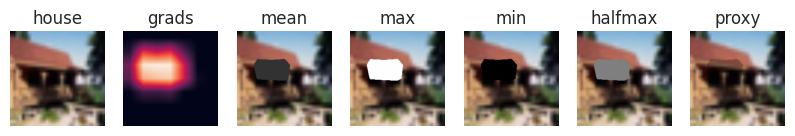

In [186]:
plot_grid(method_outputs, [label_map[int(test_label)], "grads","mean", "max", "min", "halfmax", "proxy"], rows = 1, cols = 7)

plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/methods.pdf", transparent = True)

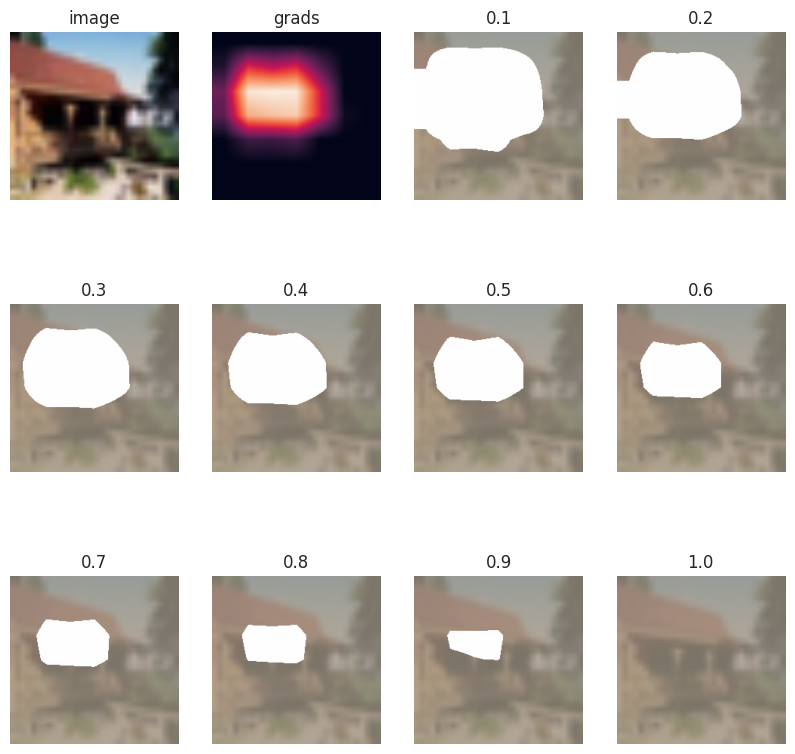

In [187]:
plot_grid(output_list, threshold_test, rows = 3)
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/grad_threshold.pdf", transparent = True)

## Explanability test

In [80]:
def plot_grid(image_list, title_list=None, rows=4, cols=4, figsize=(10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows > 1:
        for i in range(rows):
            for j in range(cols):
                img_index = i * cols + j
                if img_index < len(image_list):
                    axes[i][j].imshow(tfm(image_list[img_index]))
                    if title_list != None:
                        axes[i][j].set_title(title_list[img_index])
                axes[i][j].axis("off")
    else:
        for j in range(cols):
            img_index = j
            axes[j].imshow(tfm(image_list[img_index]))
            if title_list != None:
                axes[j].set_title(title_list[img_index])
            axes[j].axis("off")



In [81]:
def plot_images_grad(image, grads, original_labels, predicted_labels, weight=0.6, figsize=(20, 5)):
    cams = [show_cam_on_image(image[i], grads[i], weight) for i in range(len(image))]
    rows = 2
    cols = 8
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    for i in range(rows):
        for j in range(cols):
            img_index = i * cols + j
            if img_index < len(cams):
                axes[i][j].imshow(cams[img_index])
                axes[i][j].set_title(original_labels[img_index])
                axes[i][j].patch.set_linewidth('1')  
                # if original_labels[img_index] == predicted_labels[img_index]:
                #     axes[i][j].patch.set_edgecolor('green')  
                # else:
                #     axes[i][j].patch.set_edgecolor('red')  
            axes[i][j].axis("off")
    # plt.show()
    return plt


In [82]:
# Since compare_1[4] is the model with weights loaded, we can use it to predict the class of a batch of images
preds = compare_1[4](image)
# softmax and get the index of the highest probability class
preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)
predicted_labels = [label_map[int(x)] for x in preds]
original_labels = [label_map[int(lbl)] for lbl in label]

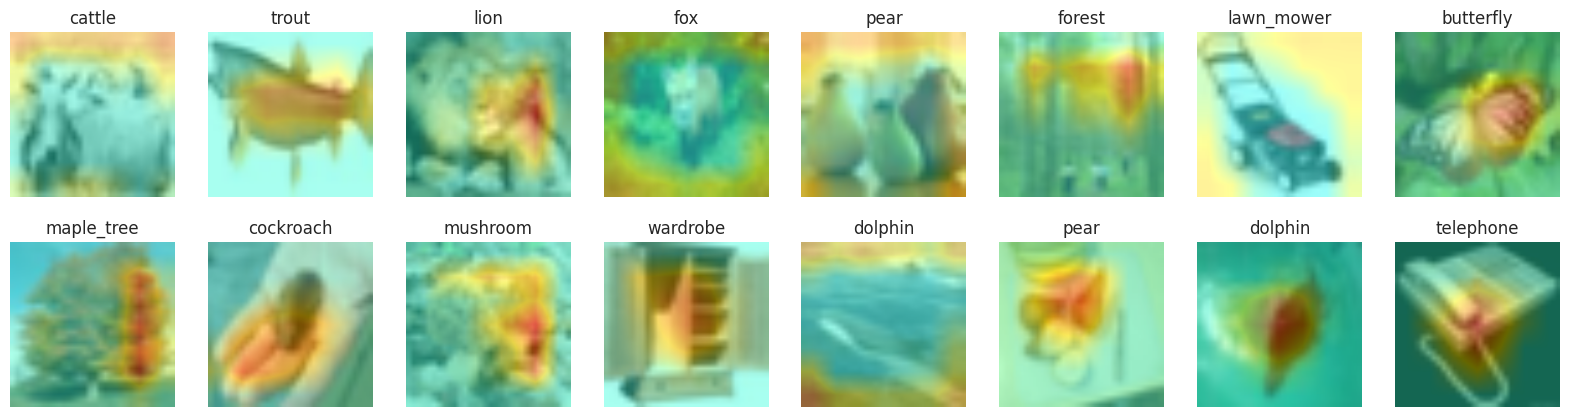

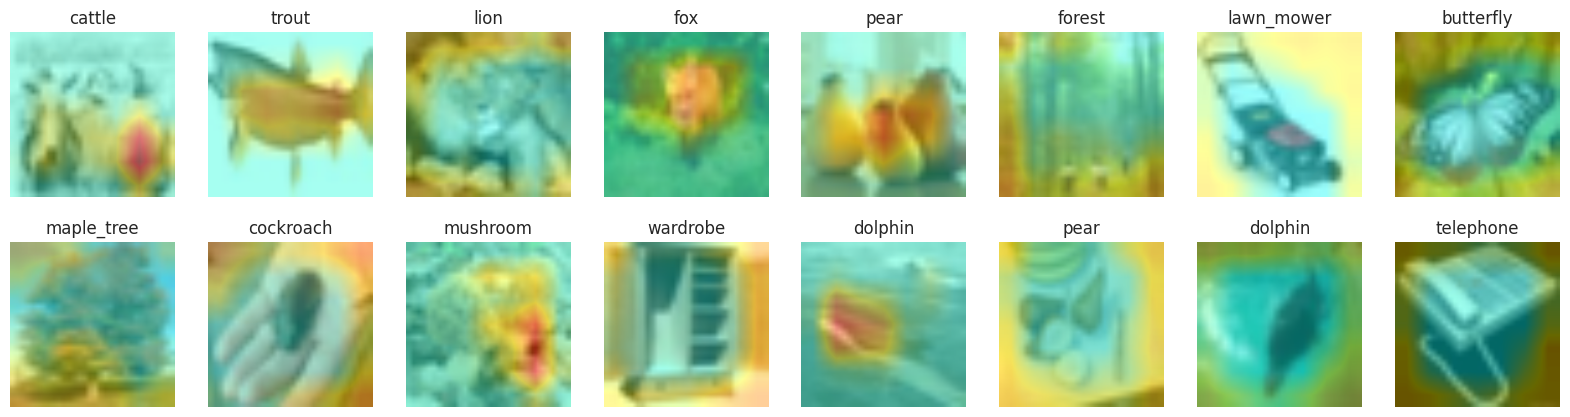

In [ ]:
plot_images_grad(image, grads_1, original_labels, predicted_labels)
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/cif_res_proxy_1.pdf",transparent = True)
plot_images_grad(image, grads_2, original_labels, predicted_labels)
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/cif_res_noproxy_1.pdf",transparent = True)

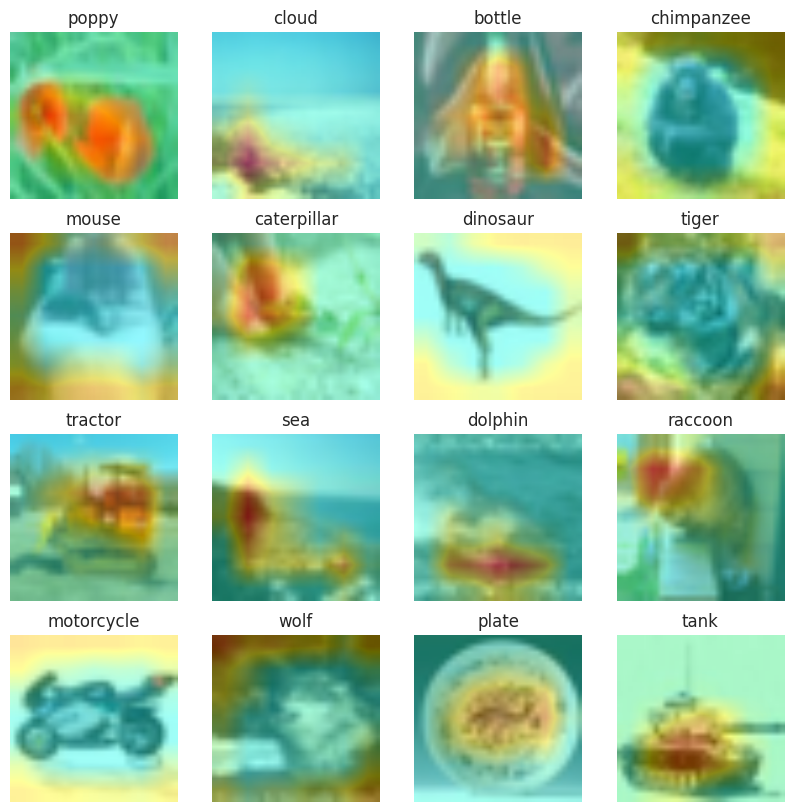

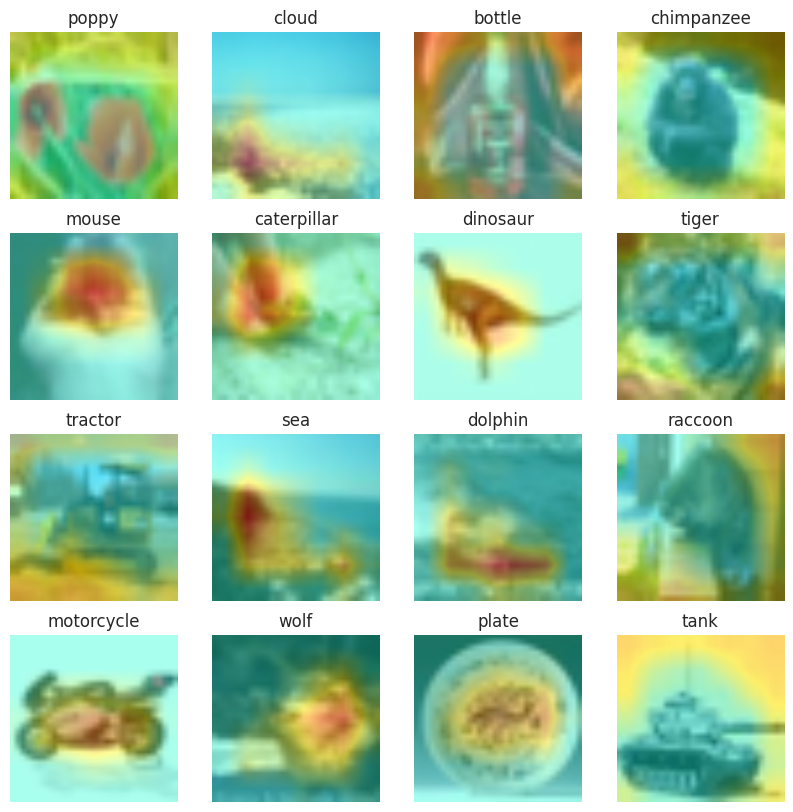

In [193]:
image,label = next(iter(dataloader))
#cam1 has proxy while cam2 does not
grads_1 = cam_1(input_tensor=image, targets=None)
grads_2 = cam_2(input_tensor=image, targets=None)


plot_images_grad(image, grads_1, [label_map[int(lbl)] for lbl in label])
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/proxy_1.pdf", transparent = True)
plot_images_grad(image, grads_2, [label_map[int(lbl)] for lbl in label])
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/noproxy_1.pdf", transparent = True)

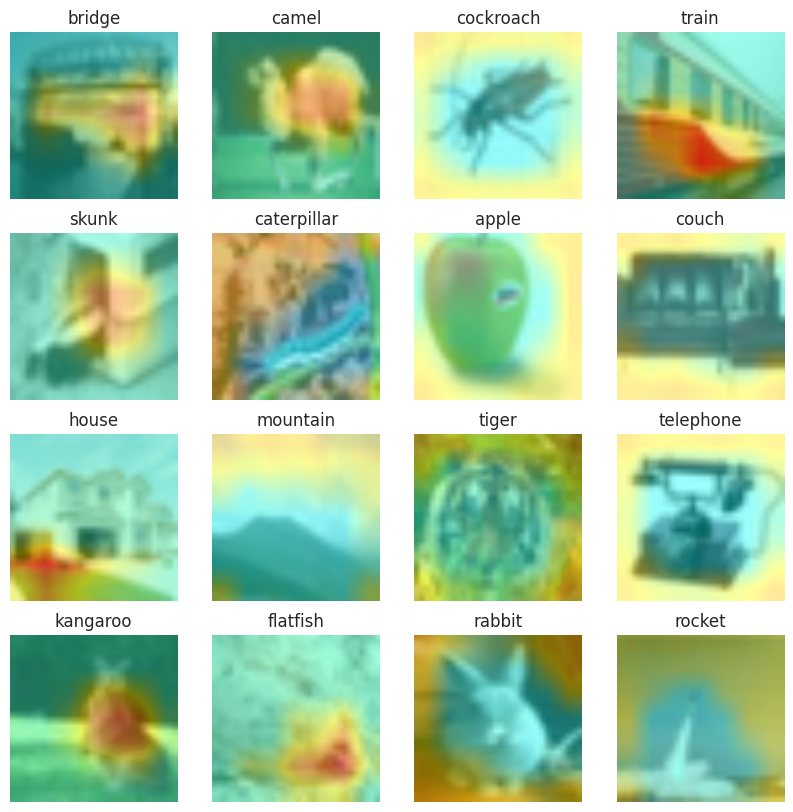

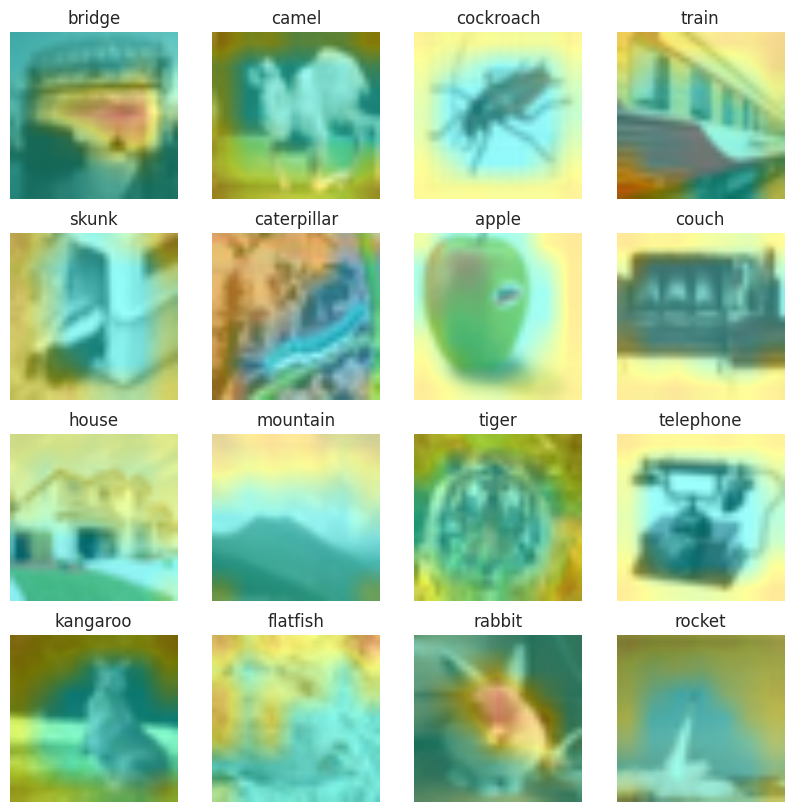

In [202]:
image,label = next(iter(dataloader))
#cam1 has proxy while cam2 does not
grads_1 = cam_1(input_tensor=image, targets=None)
grads_2 = cam_2(input_tensor=image, targets=None)


plot_images_grad(image, grads_1, [label_map[int(lbl)] for lbl in label])
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/proxy_2.pdf", transparent = True)
plot_images_grad(image, grads_2, [label_map[int(lbl)] for lbl in label])
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/noproxy_2.pdf", transparent = True)

# Caltech256, resnet18

In [204]:

select_groups = return_grouped_results(read_agg_res, ["index","ds_name", "model", "global_run_count", "final_acc", "save_path","has_proxy", "step_schedule", "num_classes"], filter={"ds_name": "caltech256", "model":"resnet18"})
select_groups["count"] = select_groups.reset_index().index
select_groups

Empty DataFrame
Columns: [accuracy, count]
Index: []

In [ ]:
index_check = [0,11]

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

tfm = transforms.ToPILImage()

In [ ]:
compare_1, compare_2 = get_row_from_index(select_groups, index_check[0]), get_row_from_index(select_groups, index_check[1])
ds_name = compare_1[-2]

In [ ]:
cam_1, cam_2 = get_single_cam(compare_1, EigenGradCAM), get_single_cam(compare_2, EigenGradCAM)
# cam_1, cam_2 = get_single_cam(compare_1), get_single_cam(compare_2)

In [ ]:
ds_val_path = ds_val_paths[ds_name]["path"]
ds_val_name_func = ds_val_paths[ds_name]["name_func"]
# Create an ImageFolder dataset using the images_folder_path
dataset = ImageFolder(ds_val_path, transform=transform)

# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
dataloader = iter(dataloader)
dataloader


In [ ]:
image,label = next(iter(dataloader))
#cam1 has proxy while cam2 does not
grads_1 = cam_1(input_tensor=image, targets=None)
grads_2 = cam_2(input_tensor=image, targets=None)


## Gradient Threshold

In [ ]:
def halfmax(x): return torch.max(x) / 2
list_test= [torch.mean, torch.max, torch.min, halfmax]

In [ ]:
proxy_threshold = 0.8
proxy_image_weight = 0.1
idx = 4
test_image = image[idx]
test_label = label[idx]
test_grads = torch.Tensor(grads_1[idx])
normalized_inps = inv_normalize(test_image)
print(test_label)

tensor(37)


In [ ]:
threshold_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

output_list = [torch.where(
    test_grads > threshold, list_test[1](test_grads), normalized_inps
) for threshold in threshold_test]

output_list.insert(0, test_grads)
output_list.insert(0, test_image)
threshold_test.insert(0, "grads")
threshold_test.insert(0, "image")


In [ ]:
method_outputs = [torch.where(
    test_grads > proxy_threshold, method(test_grads), test_image
) for method in list_test]

In [ ]:
#cifar100
label_map = eval(read_agg_res[read_agg_res["ds_name"] == "cifar100"].iloc[0]["label_map"])

In [ ]:
proxy_im = np.array(tfm(torch.where(test_grads > proxy_threshold,(1 - .3 * test_grads) * test_image, test_image,)))

In [ ]:
method_outputs.insert(0, test_grads)
method_outputs.insert(0, test_image)
method_outputs.append(proxy_im)


In [ ]:
plt.rcParams['axes.facecolor'] = 'white'

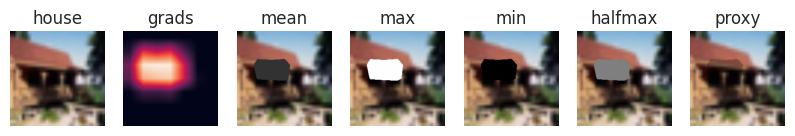

In [ ]:
plot_grid(method_outputs, [label_map[int(test_label)], "grads","mean", "max", "min", "halfmax", "proxy"], rows = 1, cols = 7)

plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/methods.pdf", transparent = True)

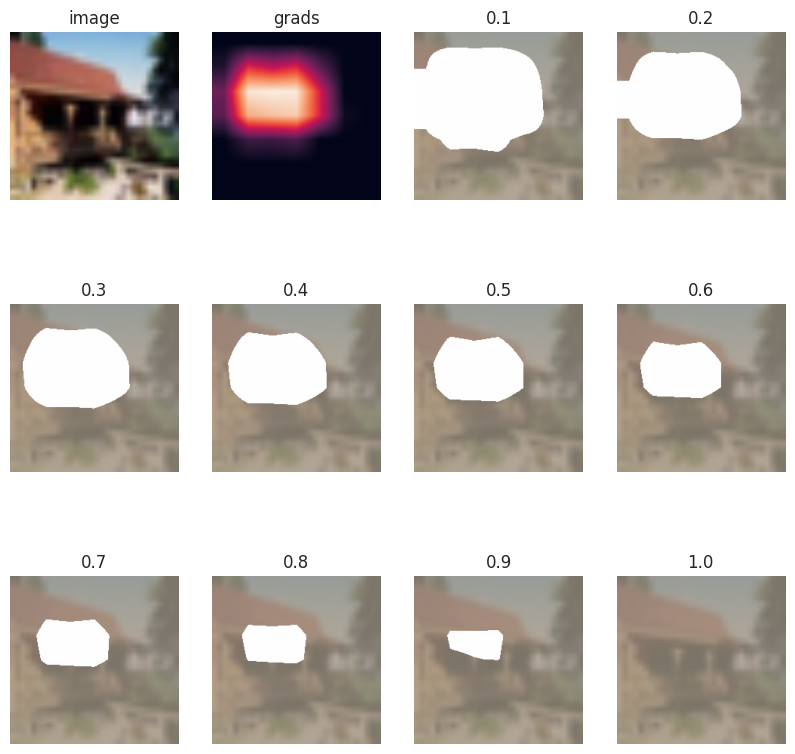

In [ ]:
plot_grid(output_list, threshold_test, rows = 3)
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/grad_threshold.pdf", transparent = True)

## Explanability test

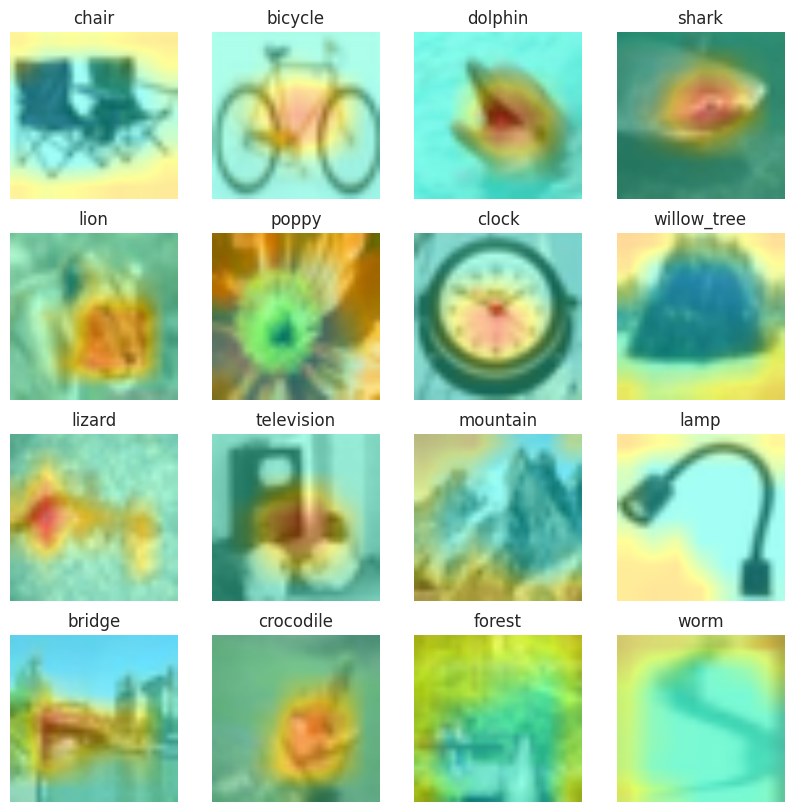

In [ ]:
plot_images_grad(image, grads_1, [label_map[int(lbl)] for lbl in label])
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/proxy.pdf",transparent = True)

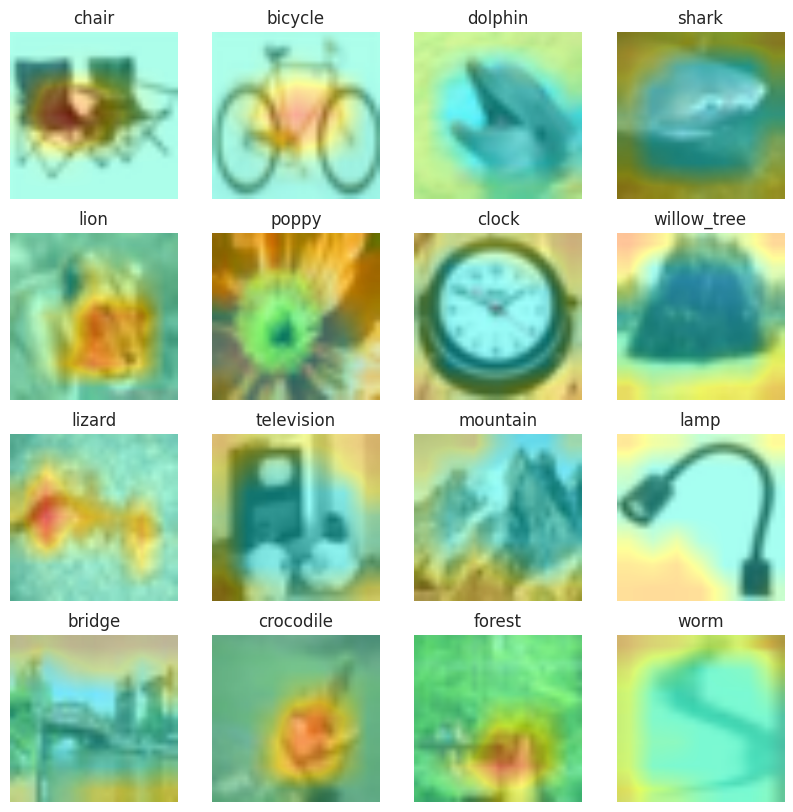

In [ ]:
plot_images_grad(image, grads_2, [label_map[int(lbl)] for lbl in label])
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/noproxy.pdf",transparent = True)

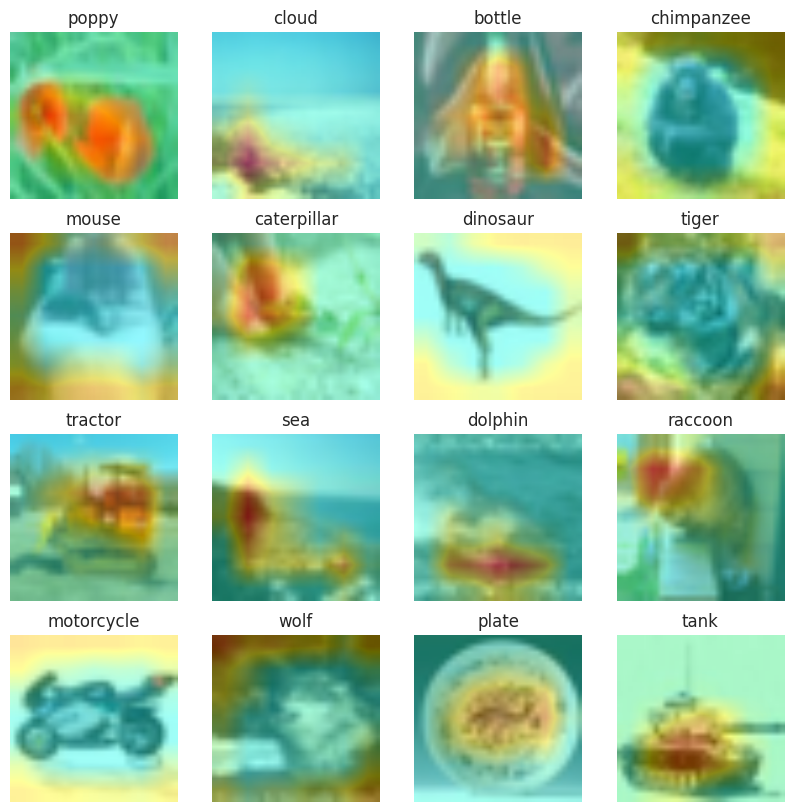

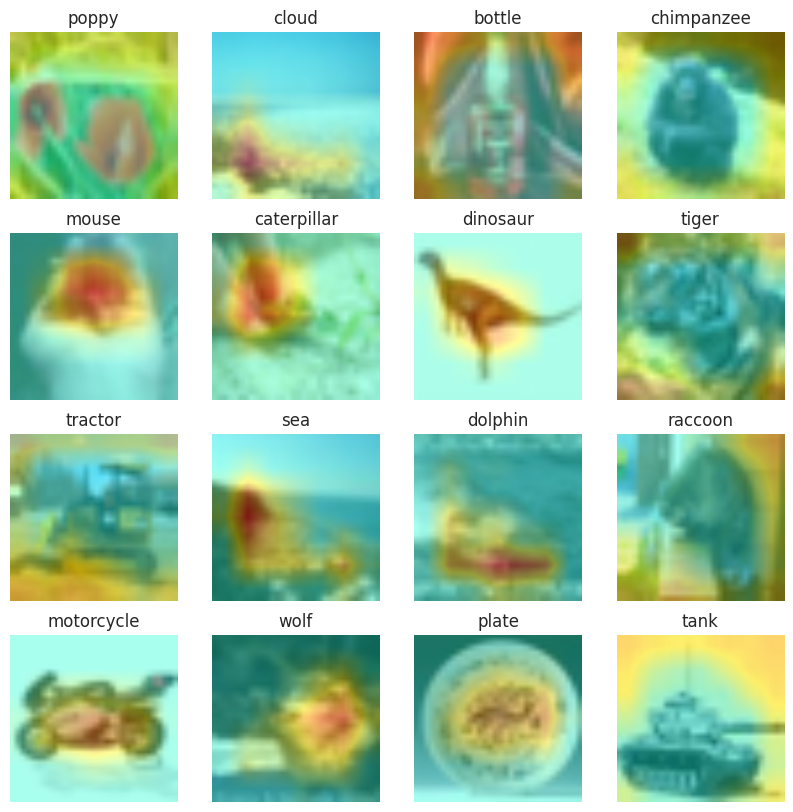

In [ ]:
image,label = next(iter(dataloader))
#cam1 has proxy while cam2 does not
grads_1 = cam_1(input_tensor=image, targets=None)
grads_2 = cam_2(input_tensor=image, targets=None)


plot_images_grad(image, grads_1, [label_map[int(lbl)] for lbl in label])
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/proxy_1.pdf", transparent = True)
plot_images_grad(image, grads_2, [label_map[int(lbl)] for lbl in label])
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/noproxy_1.pdf", transparent = True)

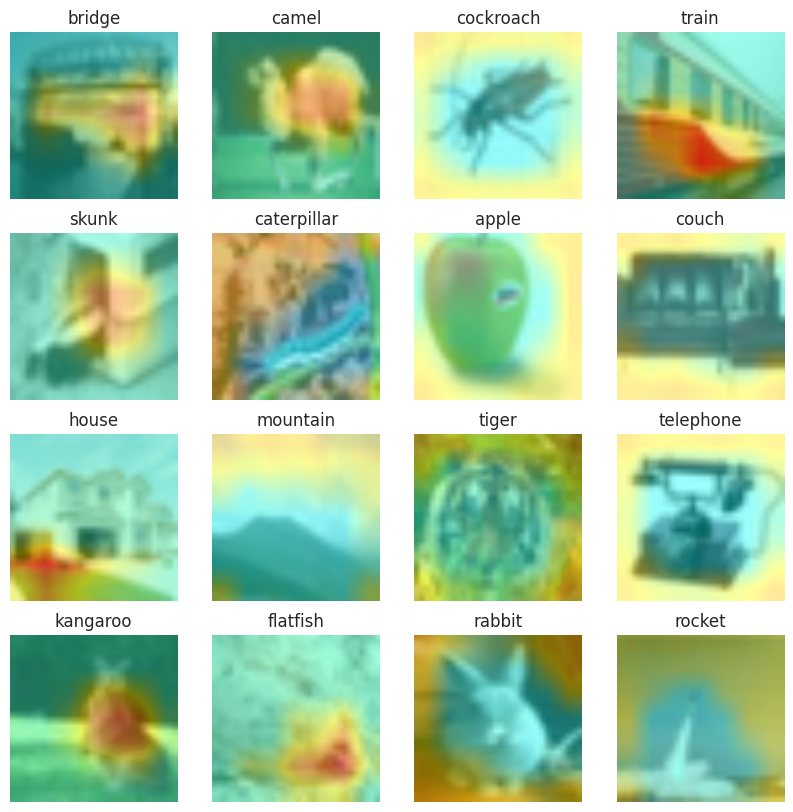

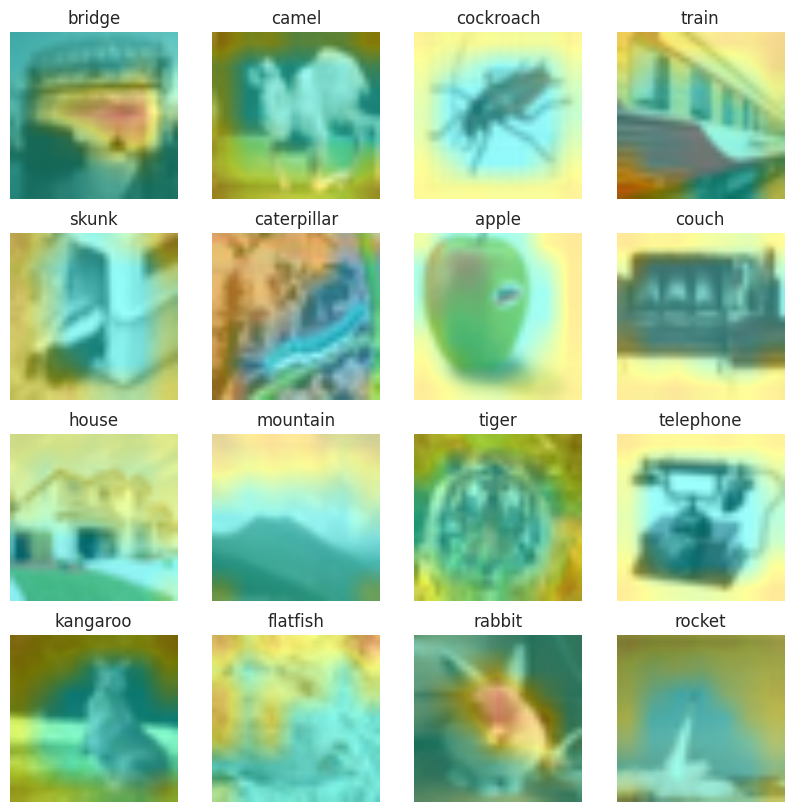

In [ ]:
image,label = next(iter(dataloader))
#cam1 has proxy while cam2 does not
grads_1 = cam_1(input_tensor=image, targets=None)
grads_2 = cam_2(input_tensor=image, targets=None)


plot_images_grad(image, grads_1, [label_map[int(lbl)] for lbl in label])
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/proxy_2.pdf", transparent = True)
plot_images_grad(image, grads_2, [label_map[int(lbl)] for lbl in label])
plt.savefig("/home/eragon/Documents/Github/proxy_attention/writing/thesis/images/noproxy_2.pdf", transparent = True)